# Basic example for bssunfold package

In [1]:
# %pip install bssunfold pandas numpy matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bssunfold import Detector

## Load the response functions file for the BSS
- first column: Energy in MeV
- other columns: detector responses for the set of moderator spheres

In [3]:
# response functions default GSF
from bssunfold import RF_GSF
df = pd.DataFrame.from_dict(RF_GSF, orient='columns')
Detector_GSF = Detector(df)

In [4]:
# reference spectrum ISO Cf-252.
reference_spectrum = {
    "E_MeV": [
        1e-09,
        1.5848931924611136e-09,
        2.5118864315095803e-09,
        3.981071705534973e-09,
        6.309573444801934e-09,
        1e-08,
        1.5848931924611143e-08,
        2.511886431509581e-08,
        3.9810717055349736e-08,
        6.309573444801934e-08,
        1.0000000000000001e-07,
        1.5848931924611143e-07,
        2.5118864315095823e-07,
        3.9810717055349735e-07,
        6.309573444801937e-07,
        1.0000000000000002e-06,
        1.584893192461114e-06,
        2.5118864315095823e-06,
        3.981071705534973e-06,
        6.309573444801937e-06,
        1e-05,
        1.584893192461114e-05,
        2.5118864315095822e-05,
        3.9810717055349776e-05,
        6.309573444801943e-05,
        0.0001,
        0.00015848931924611142,
        0.0002511886431509582,
        0.0003981071705534978,
        0.0006309573444801943,
        0.001,
        0.0015848931924611143,
        0.0025118864315095825,
        0.003981071705534978,
        0.006309573444801942,
        0.01,
        0.01584893192461114,
        0.025118864315095826,
        0.039810717055349776,
        0.06309573444801943,
        0.1,
        0.15848931924611173,
        0.25118864315095824,
        0.3981071705534969,
        0.6309573444801944,
        1.0,
        1.5848931924611174,
        2.5118864315095824,
        3.9810717055349856,
        6.309573444801943,
        10.0,
        15.848931924611176,
        25.118864315095824,
        39.810717055349855,
        63.09573444801943,
        100.0,
        158.48931924611173,
        251.18864315095823,
        398.1071705534986,
        630.9573444801944,
    ],
    "Phi": [
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0002193244132568562,
        0.000922,
        0.0017977302145640818,
        0.0033934229230273556,
        0.00638236969883396,
        0.01212580290671056,
        0.0237,
        0.04468185467401807,
        0.0822779218679577,
        0.1450462719353082,
        0.2413649401952857,
        0.359,
        0.45221093414611185,
        0.4338707690763234,
        0.2708850368693928,
        0.0856762250762,
        0.00427,
        0.0004258199483775139,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
    ],
}

In [5]:
# effective readings of the GSF BSS for the reference spectrum [reading per second]
readings = {
    "0in": 0.00037,
    "2in": 0.00999,
    "3in": 0.05366,
    "5in": 0.18417,
    "6in": 0.21968,
    "8in": 0.22007,
    "10in": 0.17214,
    "12in": 0.12033,
    "15in": 0.06674,
    "18in": 0.03411,
}

## Unfold the spectrum
1) Tikhonov regularization solded with CVXPY, ECOS solver
2) Landweber iterative unfolding
3) CVXPY results are used as initial guess for Landweber unfolding

In [6]:
result_cvxpy = Detector_GSF.unfold_cvxpy(readings, regularization=1e-4)

results = {
    "CVXPY": result_cvxpy,
    "CVXPY[ECOS]": Detector_GSF.unfold_cvxpy(
        readings, regularization=1e-4, solver="ECOS"
    ),
    "Landweber": Detector_GSF.unfold_landweber(readings, max_iterations=3000),
    "CVXPY -> Landweber": Detector_GSF.unfold_landweber(
        readings, initial_spectrum=result_cvxpy["spectrum"], max_iterations=3000
    ),
}

Status: optimal
Objective value: 8.309231389661496e-05
Residual norm: 0.000000
Result saved with key: 20260116_224123_cvxpy
Status: optimal
Objective value: 8.30896569921052e-05
Residual norm: 0.000000
Result saved with key: 20260116_224123_cvxpy
Result saved with key: 20260116_224123_Landweber
Result saved with key: 20260116_224123_Landweber


# Unfolding with uncertainty

In [7]:
# Unfold spectrum with uncertainty calculation based on Monte-Carlo
n_montecarlo = 500  # number of random samples of readings with noise
noise_level = 0.01  # Gaussian noise for readings, 5%

# 1 CVXPY
result_cvxpy_unc = Detector_GSF.unfold_cvxpy(
    readings,
    regularization=1e-4,
    calculate_errors=True,
    noise_level = noise_level,
    n_montecarlo = n_montecarlo,
)
# 2 Landweber
result_landweber_unc = Detector_GSF.unfold_landweber(
    readings, calculate_errors=True,
    noise_level = noise_level,
    n_montecarlo = n_montecarlo,
)
# 3 CVXPY -> Landweber
result_cvxpy_landweber_unc = Detector_GSF.unfold_landweber(
    readings,
    initial_spectrum=result_cvxpy_unc["spectrum"],
    max_iterations=3000,
    calculate_errors=True,
    noise_level = noise_level,
    n_montecarlo = n_montecarlo,
)

Status: optimal
Objective value: 8.309231389661496e-05
Residual norm: 0.000000
Calculating uncertainty with Monte-Carlo...
Status: optimal
Objective value: 0.0011899541699460425
Status: optimal
Objective value: 0.0007021068762922901
Status: optimal
Objective value: 0.0017918052835542897
Status: optimal
Objective value: 0.002096928829969295
Status: optimal
Objective value: 0.0007700330017054943
Status: optimal
Objective value: 0.0022814397896840964
Status: optimal
Objective value: 0.0009701668874029941
Status: optimal
Objective value: 0.0009762533787146486
Status: optimal
Objective value: 0.0022327342484550518
Status: optimal
Objective value: 0.002038782014784831
Status: optimal
Objective value: 0.0017791715566916747
Status: optimal
Objective value: 0.0004746119060598964
Status: optimal
Objective value: 0.0014939131708038016
Status: optimal
Objective value: 0.0009916670430114233
Status: optimal
Objective value: 0.0015568108415380522
Status: optimal
Objective value: 0.002158779616150634


# Plot spectra with uncertanity

- use of Landweber iterations to stabilize the solution from CVXPY

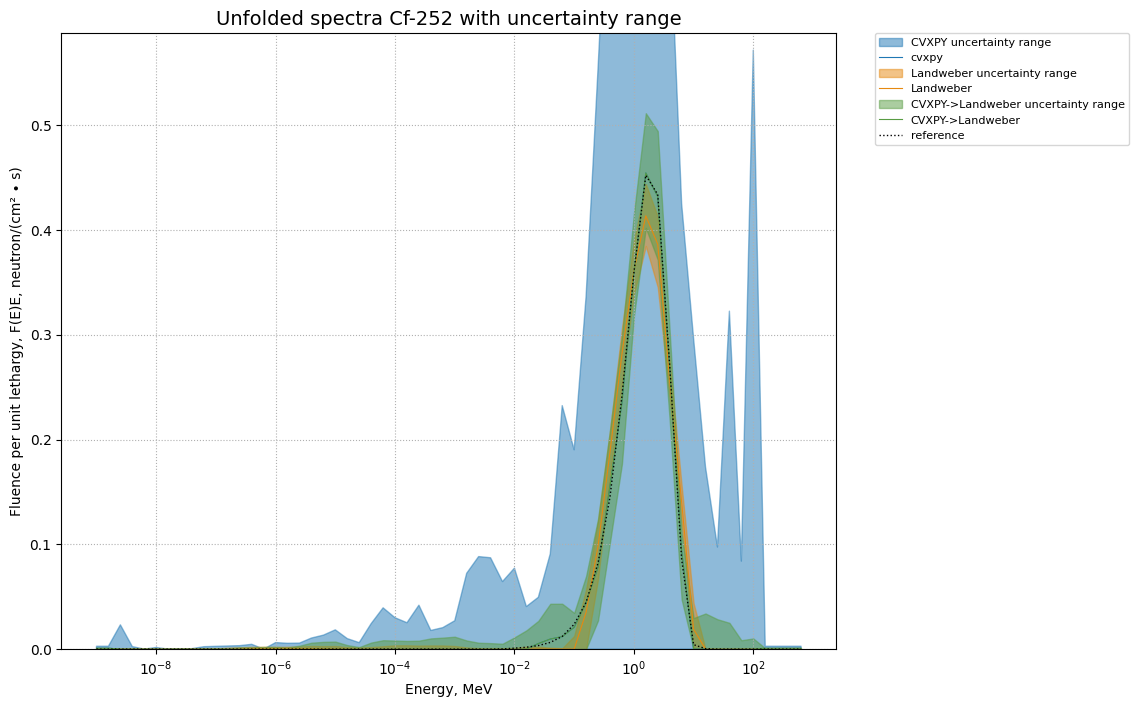

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
methods = list(results.keys())
all_labels = ["reference"] + methods

colors = ["black", "#1f77b4", "#e68910", "#589c43", "indianred"]
# Первый график (спектры)

ax.fill_between(
    result_cvxpy_unc["energy"],
    result_cvxpy_unc["spectrum_uncert_min"],
    result_cvxpy_unc["spectrum_uncert_max"],
    alpha=0.5,
    color=colors[1],
    label="CVXPY uncertainty range",
)

ax.plot(
    result_cvxpy_unc["energy"],
    result_cvxpy_unc["spectrum"],
    label="cvxpy",
    color=colors[1],
    ls="-",
    linewidth=0.8,
    alpha=1,
)

ax.fill_between(
    result_landweber_unc["energy"],
    result_landweber_unc["spectrum_uncert_min"],
    result_landweber_unc["spectrum_uncert_max"],
    alpha=0.5,
    color=colors[2],
    label="Landweber uncertainty range",
)

ax.plot(
    result_landweber_unc["energy"],
    result_landweber_unc["spectrum"],
    label="Landweber",
    color=colors[2],
    ls="-",
    linewidth=0.8,
    alpha=1,
)

# CVXPY -> Landweber
ax.fill_between(
    result_cvxpy_landweber_unc["energy"],
    result_cvxpy_landweber_unc["spectrum_uncert_min"],
    result_cvxpy_landweber_unc["spectrum_uncert_max"],
    alpha=0.5,
    color=colors[3],
    label="CVXPY->Landweber uncertainty range",
)

ax.plot(
    result_cvxpy_landweber_unc["energy"],
    result_cvxpy_landweber_unc["spectrum"],
    label="CVXPY->Landweber",
    color=colors[3],
    ls="-",
    linewidth=0.8,
    alpha=1,
)



ax.plot(
    reference_spectrum["E_MeV"],
    reference_spectrum["Phi"],
    label="reference",
    linewidth=1,
    linestyle=":",
    color=colors[0],
)

ax.set_xlabel("Energy, MeV")
ax.set_ylabel("Fluence per unit lethargy, F(E)E, neutron/(cm² ∙ s)")
ax.set_xscale("log")
ax.set_ylim(0,np.max(reference_spectrum["Phi"])*1.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, fontsize=8)
ax.grid(True, which="both", ls=":")
ax.set_title(f"Unfolded spectra Cf-252 with uncertainty range", fontsize=14)
plt.show()

# Barplot with uncertainty

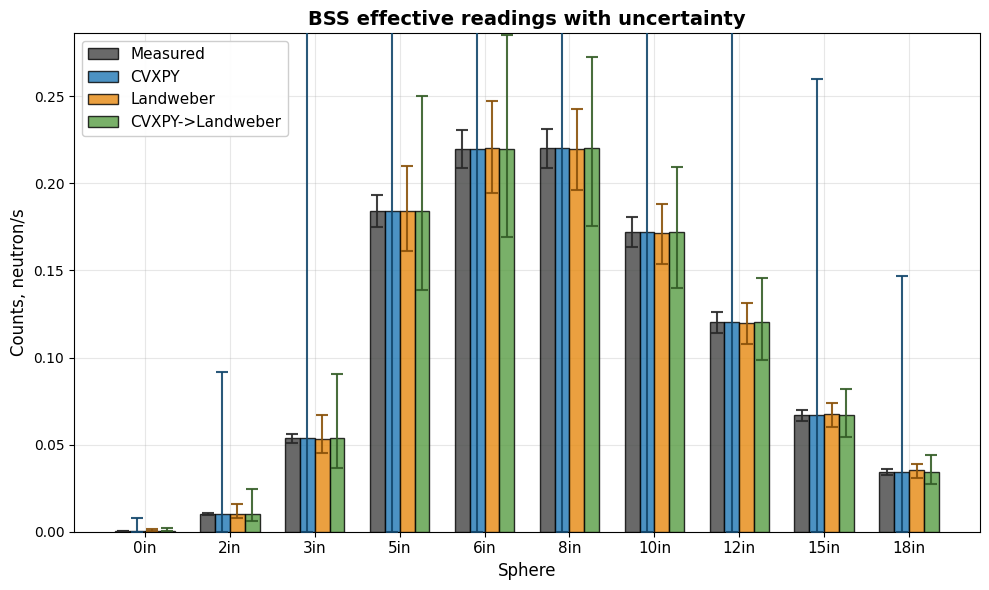

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

# Data preparation (в начале!)
categories = list(readings.keys())
ref_values = [readings[cat] for cat in categories]

# Define datasets
datasets = {
    'ref': {
        'values': ref_values,
        'color': '#434443',
        'label': 'Measured'
    },
    'cvxpy': {
        'values': [result_cvxpy_unc["effective_readings"][cat] for cat in categories],
        'color': '#1f77b4', 
        'label': 'CVXPY',
        'uncert_min': result_cvxpy_unc['spectrum_uncert_min'],
        'uncert_max': result_cvxpy_unc['spectrum_uncert_max']
    },
    'landweber': {
        'values': [result_landweber_unc["effective_readings"][cat] for cat in categories],
        'color': '#e68910',
        'label': 'Landweber',
        'uncert_min': result_landweber_unc['spectrum_uncert_min'],
        'uncert_max': result_landweber_unc['spectrum_uncert_max']
    },
    'cvxpy_landweber': {
        'values': [result_cvxpy_landweber_unc["effective_readings"][cat] for cat in categories],
        'color': '#589c43',
        'label': 'CVXPY->Landweber',
        'uncert_min': result_cvxpy_landweber_unc['spectrum_uncert_min'],
        'uncert_max': result_cvxpy_landweber_unc['spectrum_uncert_max']
    }
}

# Создаем фигуру ПЕРЕД plotting
plt.figure(figsize=(10, 6))

# Positions
n_datasets, n_cats = len(datasets), len(categories)
x_pos = np.arange(n_cats)
width = 0.7 / n_datasets
offsets = np.linspace(-width * (n_datasets - 1) / 2, width * (n_datasets - 1) / 2, n_datasets)
A_mat = Detector_GSF.Amat.T

# Plot all bars and errors
for i, (name, data) in enumerate(datasets.items()):
    pos = x_pos + offsets[i]
    
    # Bars
    bars = plt.bar(pos, data['values'], width, label=data['label'], 
                   color=data['color'], edgecolor='black', alpha=0.8, zorder=3)
    
    # Error bars
    if name == 'ref':
        yerr_lower = [v * 0.05 for v in data['values']]
        yerr_upper = [v * 0.05 for v in data['values']]
        ecolor = '#2a2a2a'
    else:
        uncert_min = A_mat @ data['uncert_min']
        uncert_max = A_mat @ data['uncert_max']
        yerr_lower = [data['values'][j] - uncert_min[j] for j in range(n_cats)]
        yerr_upper = [uncert_max[j] - data['values'][j] for j in range(n_cats)]
        # Темный оттенок оригинального цвета
        rgb = to_rgb(data['color'])
        ecolor = tuple(c * 0.6 for c in rgb)
    
    plt.errorbar(pos, data['values'], yerr=[yerr_lower, yerr_upper], 
                fmt='none', ecolor=ecolor, elinewidth=1.5, capsize=4, 
                capthick=1.5, alpha=0.9, zorder=4)

# Styling (ТЕПЕРЬ работает!)
plt.title('BSS effective readings with uncertainty', fontsize=14, fontweight='bold')
plt.xlabel('Sphere', fontsize=12)
plt.ylabel('Counts, neutron/s', fontsize=12)
plt.xticks(x_pos, categories, fontsize=11)
plt.ylim(0, max(ref_values) * 1.3)
plt.grid(True, alpha=0.3, zorder=0)

plt.legend(fontsize=11, loc='upper left', framealpha=0.95)
plt.tight_layout()
plt.show()
